#### **Code to evaluate the before/after priors in terms of cortical fanning**

Will used the cortico-spinal tract (CST) as the bundle for this test.


In [1]:
# Imports
import os

import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel
import seaborn as sns

In [2]:
# Set root Dir for the project.
ROOT_DIR = "/Users/anthonygagnon/Documents/École/Université/Projects/nf-pediatric/"
RESULTS_DIR = ROOT_DIR + "Fanning/"

# Dataset folder
PING_DATA = ROOT_DIR + "/PING/"
BCP_DATA = ROOT_DIR + "/BCP/"
BANDA_DATA = ROOT_DIR + "/BANDA/"
GESTE_DATA = ROOT_DIR + "/GESTE/"
ABCD_DATA = ROOT_DIR + "/ABCD/"
MYRNA_DATA = ROOT_DIR + "/MYRNA/"

# Create a directory for the results if it doesn't exist
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

In [3]:
# Fetch Harding font.
font_files = []
for fontpath in font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Harding".lower() in fontpath.lower():
        font_files.append(fontpath)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Set Harding font.
plt.rcParams['font.family'] = 'Harding Text Web'

# Set the Set2 color palette as an iterable.
cmap = sns.color_palette("Set2", 8)

In [4]:
# Load up the before and after data.
before = pd.read_csv(BCP_DATA + "noPriors/bundles_mean_stats.tsv", sep='\t')
after = pd.read_csv(BCP_DATA + "withPriors/bundles_mean_stats.tsv", sep='\t')

# Filter to only include subjects found in both datasets.
common_subjects = set(before['sample']).intersection(set(after['sample']))
before = before[before['sample'].isin(common_subjects)].sort_values('sample').reset_index(drop=True)
after = after[after['sample'].isin(common_subjects)].sort_values('sample').reset_index(drop=True)

# Assert that both dataframes have the same subjects in the same order.
assert all(before['sample'].unique() == after['sample'].unique()), "Subjects do not match between before and after datasets."

In [5]:
# We will only look at the CST, so filter bundles matching either "PYT_L" or "PYT_R".
before_cst = before[before['bundle'].isin(['PYT_L', 'PYT_R'])].reset_index(drop=True)
after_cst = after[after['bundle'].isin(['PYT_L', 'PYT_R'])].reset_index(drop=True)

before_cst.head()

,sample,session,bundle,ad,afd_fixel,afd_max,afd_sum,afd_total,fa,md,...,mean_length_mm,mean_length_nb_points,mean_step_size,min_length_mm,min_length_nb_points,min_step_size,number_streamlines,std_length_mm,std_length_nb_points,std_step_size
0,sub-011228,ses-46mo,PYT_R,0.001224,0.571169,1.340718,0.981747,0.388149,0.529148,0.000732,...,97.217693,33.184034,3.020681,51.206778,15.0,0.061551,12389,8.810211,3.529615,1.112646
1,sub-011228,ses-46mo,PYT_L,0.001201,0.417569,1.401341,1.023506,0.409248,0.525533,0.000718,...,99.026579,33.623615,3.035426,55.937561,19.0,0.017254,13449,9.663919,3.780591,1.118206
2,sub-011228,ses-12mo,PYT_R,0.001231,0.470950,1.120228,0.832173,0.352690,0.433235,0.000808,...,94.292961,32.452704,2.997929,40.122361,14.0,0.101933,5677,10.367082,3.994371,1.104131
3,sub-011228,ses-12mo,PYT_L,0.001216,0.316073,1.094304,0.813734,0.348346,0.421172,0.000806,...,110.056670,37.783285,2.992029,50.082215,16.0,0.062920,11702,12.796996,4.884256,1.104670
4,sub-011228,ses-18mo,PYT_L,0.001197,0.363703,1.165565,0.863746,0.365219,0.440729,0.000782,...,112.525365,38.475545,3.002635,51.509845,17.0,0.093984,18013,12.415725,4.782591,1.107413


In [6]:
# Now, let's do a left dataframe including only the end_surface_area_tail metric.
before_cst_tail = before_cst[['sample', 'session', 'bundle', 'end_surface_area_tail']].copy()
before_cst_tail = before_cst_tail.rename(columns={'end_surface_area_tail': 'before_end_surface_area_tail'})
after_cst_tail = after_cst[['sample', 'session', 'bundle', 'end_surface_area_tail']].copy()
after_cst_tail = after_cst_tail.rename(columns={'end_surface_area_tail': 'after_end_surface_area_tail'})
merged_cst_tail = pd.merge(before_cst_tail, after_cst_tail, on=['sample', 'session', 'bundle'])
#Print some useful info.
print(f"Number of subjects in before dataset: {before_cst_tail['sample'].nunique()}")
print(f"Number of subjects in after dataset: {after_cst_tail['sample'].nunique()}")
print(f"Number of subjects in merged dataset: {merged_cst_tail['sample'].nunique()}")

Number of subjects in before dataset: 259
Number of subjects in after dataset: 259
Number of subjects in merged dataset: 258


In [7]:
# Is there 0 values ? 
print(f"Number of 0 values in before dataset: {(merged_cst_tail['before_end_surface_area_tail'] == 0).sum()}")
print(f"Number of 0 values in after dataset: {(merged_cst_tail['after_end_surface_area_tail'] == 0).sum()}")

# We should remove potential outliers (e.g., values that are 3 standard deviations away from the mean).
before_mean = merged_cst_tail['before_end_surface_area_tail'].mean()
before_std = merged_cst_tail['before_end_surface_area_tail'].std()
after_mean = merged_cst_tail['after_end_surface_area_tail'].mean()
after_std = merged_cst_tail['after_end_surface_area_tail'].std()

merged_cst_tail_filtered = merged_cst_tail[
    (np.abs(merged_cst_tail['before_end_surface_area_tail'] - before_mean) <= 3 * before_std) &
    (np.abs(merged_cst_tail['after_end_surface_area_tail'] - after_mean) <= 3 * after_std)
].reset_index(drop=True)
print(f"Number of subjects in filtered merged dataset: {merged_cst_tail_filtered['sample'].nunique()}")

Number of 0 values in before dataset: 0
Number of 0 values in after dataset: 0
Number of subjects in filtered merged dataset: 258


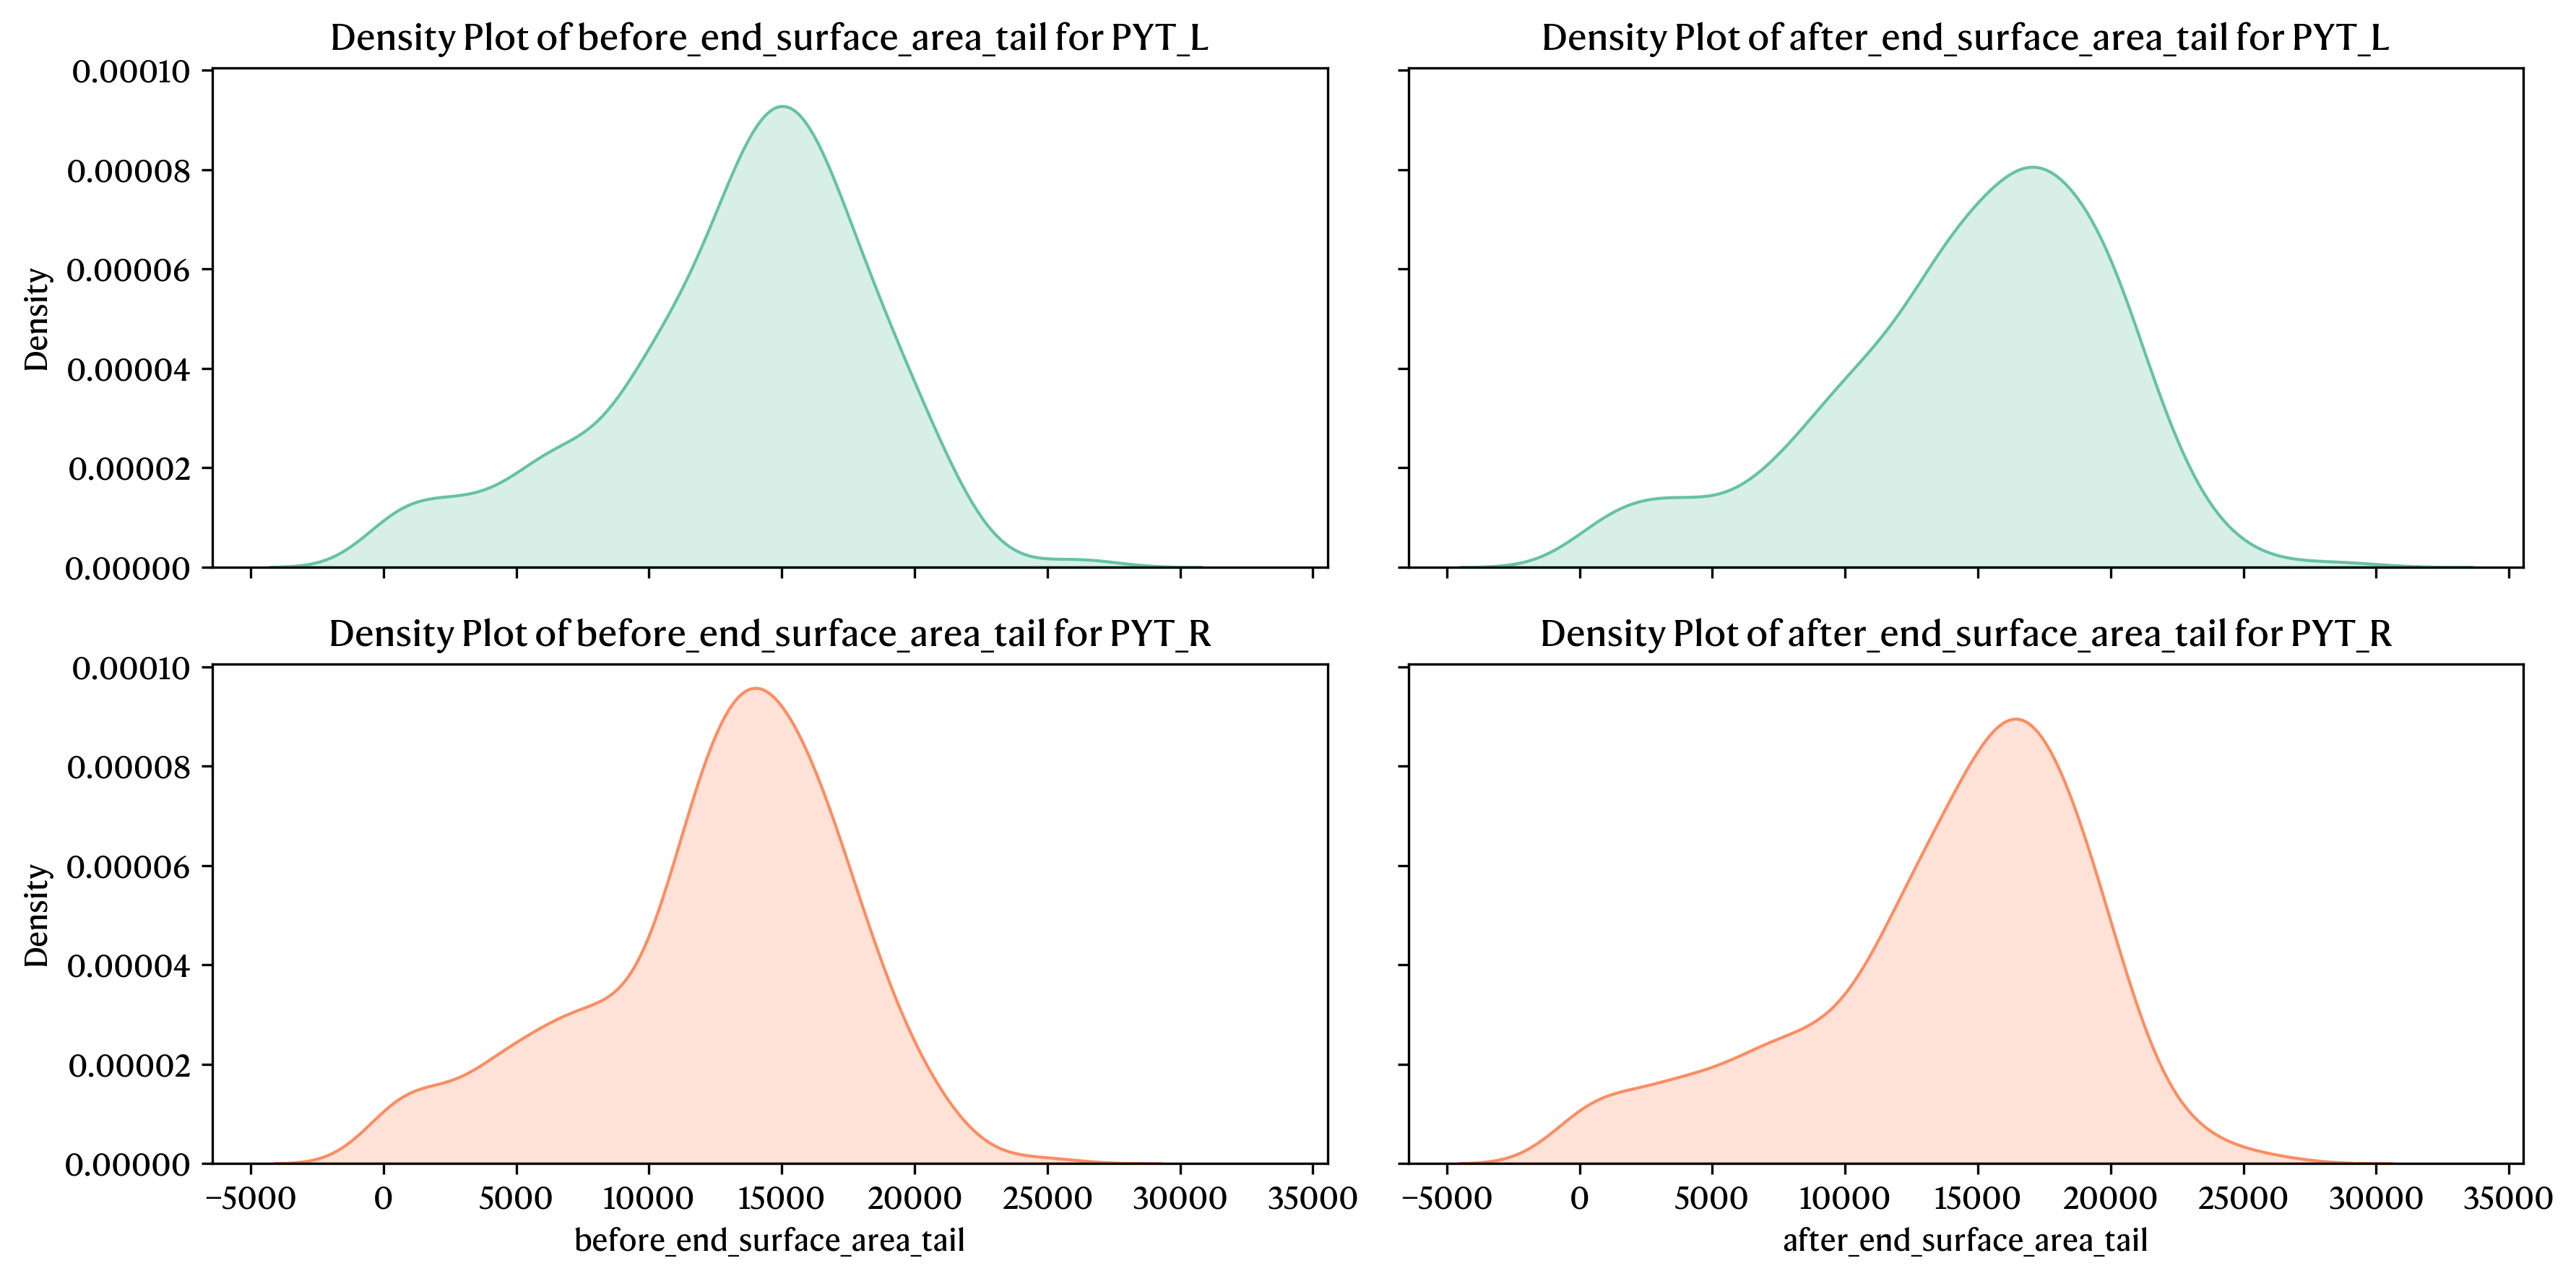

In [8]:
# Assess for possible outliers in for each side and each metric (4 plots).
# Do density plots, each side in a different plot.
fig, axes = plt.subplots(2, 2, figsize=(12, 6), dpi=300, sharey=True, sharex=True)
sides = ['PYT_L', 'PYT_R']
metrics = ['before_end_surface_area_tail', 'after_end_surface_area_tail']
for i, side in enumerate(sides):
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        sns.kdeplot(data=merged_cst_tail_filtered[merged_cst_tail_filtered['bundle'] == side], x=metric, fill=True, ax=ax, color=cmap[i])
        ax.set_title(f'Density Plot of {metric} for {side}')
        ax.set_xlabel(metric)
        ax.set_ylabel('Density')
plt.tight_layout()
plt.show()

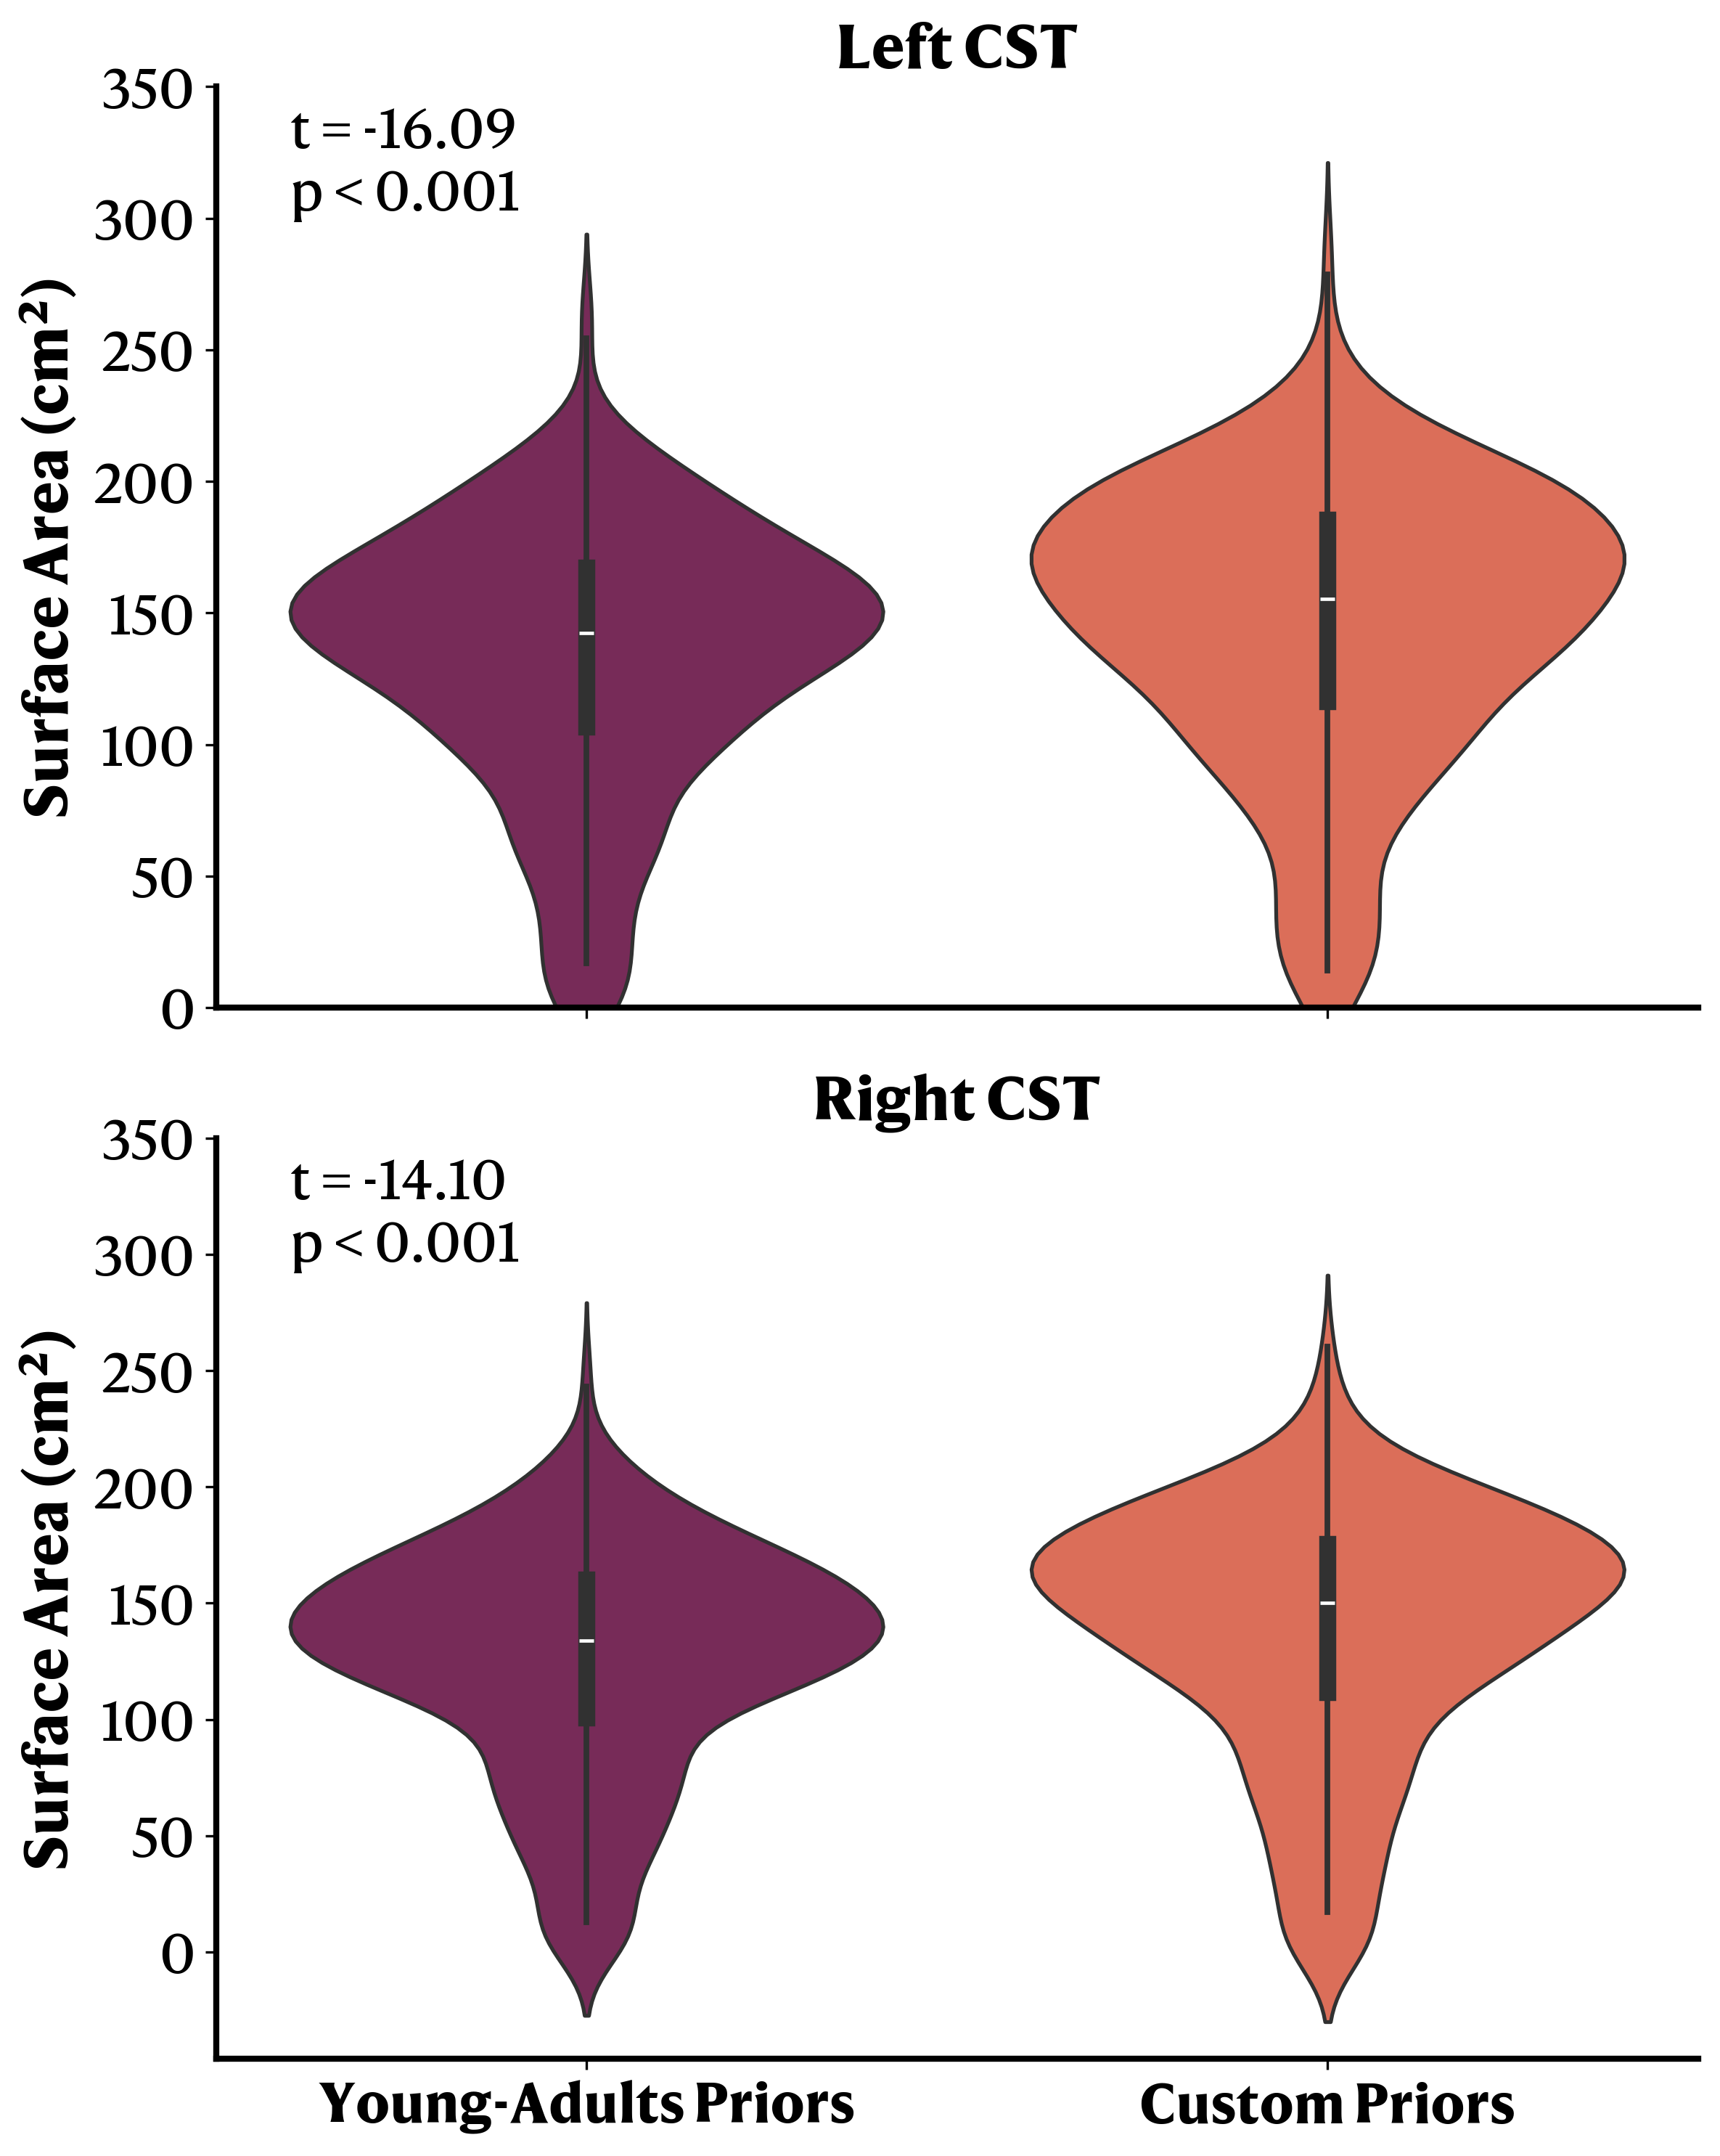

In [10]:
# Let's do a violin plot to compare the distributions of the end_surface_area_tail metric before and after adding priors.
# Split into left and right CST for plotting.
left_df = merged_cst_tail_filtered[merged_cst_tail_filtered['bundle'] == 'PYT_L']
right_df = merged_cst_tail_filtered[merged_cst_tail_filtered['bundle'] == 'PYT_R']

# The columns are in mm² but we should move that to cm² for better readability.
left_df.loc[:, 'before_end_surface_area_tail'] = left_df['before_end_surface_area_tail'] / 100
left_df.loc[:, 'after_end_surface_area_tail'] = left_df['after_end_surface_area_tail'] / 100
right_df.loc[:, 'before_end_surface_area_tail'] = right_df['before_end_surface_area_tail'] / 100
right_df.loc[:, 'after_end_surface_area_tail'] = right_df['after_end_surface_area_tail'] / 100

fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True, sharey=False, dpi=300)
sns.violinplot(data=pd.melt(left_df, id_vars=['sample', 'session', 'bundle'], value_vars=['before_end_surface_area_tail', 'after_end_surface_area_tail']),
               x='variable', y='value', palette='rocket', hue='variable', legend=False,
               ax=ax[0])
ax[0].set_ylabel('Surface Area (cm²)', fontdict={'size': 20, 'weight': 'bold'})
ax[0].set_xlabel('')
ax[0].set_ylim(0, 350)
ax[0].set_yticks(np.arange(0, 351, 50), [str(i) for i in np.arange(0, 351, 50)], fontdict={'size': 18})
ax[0].set_xticks([0, 1], ['Young-Adults Priors', 'Custom Priors'], fontdict={'size': 18, 'weight': 'bold'})
ax[0].set_title('Left CST', fontdict={'size': 20, 'weight': 'bold'})

# Let's add the one-sided t-test result to the plot.
t_stat, p_value = ttest_rel(left_df['before_end_surface_area_tail'], left_df['after_end_surface_area_tail'], nan_policy='omit',
                            alternative='less')
# Place the text on the top left of the plot.
ax[0].text(0.05, 0.98,
         f't = {t_stat:.2f}\np < {0.001 if p_value < 0.001 else f"{p_value:.3f}"}', 
         ha='left', va='top', fontsize=18, transform=ax[0].transAxes)
ax[0].spines[["left", "bottom"]].set_linewidth(2)
ax[0].spines[["top", "right"]].set_visible(False)

sns.violinplot(data=pd.melt(right_df, id_vars=['sample', 'session', 'bundle'], value_vars=['before_end_surface_area_tail', 'after_end_surface_area_tail']),
               x='variable', y='value', palette='rocket', hue='variable', legend=False,
               ax=ax[1])
ax[1].set_ylabel('Surface Area (cm²)', fontdict={'size': 20, 'weight': 'bold'})
ax[1].set_xlabel('')
ax[1].set_xticks([0, 1], ['Young-Adults Priors', 'Custom Priors'], fontdict={'size': 18, 'weight': 'bold'}, rotation=0)
ax[1].set_yticks(np.arange(0, 351, 50), [str(i) for i in np.arange(0, 351, 50)], fontdict={'size': 18})
ax[1].set_title('Right CST', fontdict={'size': 20, 'weight': 'bold'})

# Let's add the one-sided t-test result to the plot.
t_stat, p_value = ttest_rel(right_df['before_end_surface_area_tail'], right_df['after_end_surface_area_tail'], nan_policy='omit',
                            alternative='less')
ax[1].text(0.05, 0.98,
         f't = {t_stat:.2f}\np < {0.001 if p_value < 0.001 else f"{p_value:.3f}"}', 
         ha='left', va='top', fontsize=18, transform=ax[1].transAxes)

# Spines
ax[1].spines[["left", "bottom"]].set_linewidth(2)
ax[1].spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.savefig(RESULTS_DIR + 'end_surface_area_tail_violin_plot.png', dpi=300)
plt.show()

In [11]:
# Let's find for both sides, the participant (with its session) that had the largest increase in end_surface_area_tail after adding priors.
# Calculate the difference.
merged_cst_tail_filtered['difference'] = merged_cst_tail_filtered['after_end_surface_area_tail'] - merged_cst_tail_filtered['before_end_surface_area_tail']
# Find the max increase for each side.
max_increase_left = merged_cst_tail_filtered[merged_cst_tail_filtered['bundle'] == 'PYT_L'].loc[merged_cst_tail_filtered[merged_cst_tail_filtered['bundle'] == 'PYT_L']['difference'].idxmax()]
max_increase_right = merged_cst_tail_filtered[merged_cst_tail_filtered['bundle'] == 'PYT_R'].loc[merged_cst_tail_filtered[merged_cst_tail_filtered['bundle'] == 'PYT_R']['difference'].idxmax()]
print("Participant with largest increase in end_surface_area_tail for Left CST:")
print(max_increase_left)
print("\nParticipant with largest increase in end_surface_area_tail for Right CST:")
print(max_increase_right)

Participant with largest increase in end_surface_area_tail for Left CST:
sample                          sub-661045
session                           ses-42mo
bundle                               PYT_L
before_end_surface_area_tail          72.0
after_end_surface_area_tail         9002.0
difference                          8930.0
Name: 632, dtype: object

Participant with largest increase in end_surface_area_tail for Right CST:
sample                          sub-950202
session                            ses-2mo
bundle                               PYT_R
before_end_surface_area_tail        1172.0
after_end_surface_area_tail        10668.0
difference                          9496.0
Name: 961, dtype: object


In [14]:
# Print out the values for the sub-950202 participant for both sides and before/after values.
# Convert the values to cm² for readability.
participant_id = 'sub-950202'
for side in ['PYT_L', 'PYT_R']:
    participant_data = merged_cst_tail_filtered[(merged_cst_tail_filtered['sample'] == participant_id) & (merged_cst_tail_filtered['bundle'] == side)]
    if not participant_data.empty:
        before_value = participant_data['before_end_surface_area_tail'].values[0] / 100  # Convert to cm²
        after_value = participant_data['after_end_surface_area_tail'].values[0] / 100    # Convert to cm²
        print(f"{side} - Participant {participant_id}: Before = {before_value:.2f} cm², After = {after_value:.2f} cm²")
    else:
        print(f"{side} - Participant {participant_id} not found in the dataset.")

PYT_L - Participant sub-950202: Before = 44.18 cm², After = 102.08 cm²
PYT_R - Participant sub-950202: Before = 11.72 cm², After = 106.68 cm²
